# 1 - Generating Inputfile Combinations

In [1]:
# if running on google colab, uncomment the next line and execute this cell to install the dependencies and prevent "ModuleNotFoundError" in later cells:
# !pip install -r https://raw.githubusercontent.com/shirubana/Approaches2BifacialPerformanceMonitoring/main/requirements.txt

In [2]:
fielddataFolder = 'FieldData'
InputFilesFolder = 'InputFiles'
debugflag = False

In [3]:
import pandas as pd
print(f'Pandas version: {pd.__version__}')  #pandas needs to be 1.5 to be able to read the pickle file.
import matplotlib.pyplot as plt
import pvlib
import numpy as np
import os

Pandas version: 1.5.3


In [4]:
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (12, 4)

## Read Pickle with all rows data

This pickle is all the rows together, with data starting on 03/08 and ending on 07/29

In [5]:
cloud = False
if cloud:
    import cloudpickle as cp
    from urllib.request import urlopen
    data = cp.load(urlopen("https://drive.google.com/file/d/pickled_file", 'rb'))
else:
    try:
        data = pd.read_pickle(os.path.join(fielddataFolder,'DATA_Release.pickle'))
    except AttributeError:
        raise Exception('Error: pandas needs to be >= 1.5.0 to read this pickle file')
        
print("Clean pickle loaded for Plotting Production Data, # datapoints: ", data.__len__())
print("Spanning from", data.index[0], " to ", data.index[-1])

Clean pickle loaded for Plotting Production Data, # datapoints:  1665830
Spanning from 2019-07-01 00:02:00-07:00  to  2022-09-07 23:20:00-07:00


In [6]:
data.keys()

Index(['row2kWh', 'row2dcp', 'row2Gfront', 'Hydra_current_1',
       'Hydra_current_10', 'Hydra_current_11', 'Hydra_current_12',
       'Hydra_current_2', 'Hydra_current_3', 'Hydra_current_4',
       'Hydra_current_5', 'Hydra_current_6', 'Hydra_current_7',
       'Hydra_current_8', 'Hydra_current_9', 'row2temperature_ambient',
       'row2tmod_1', 'row2tmod_2', 'row2wind_direction', 'row2wind_speed',
       'row3Gfront', 'row3Grear_IMT_West', 'row3Grear_IMT_CenterWest',
       'row3Grear_IMT_CenterEast', 'row3Grear_IMT_East', 'row3Grear_CM11',
       'row3Grear_Licor', 'row3Gfront_CM11', 'row3Gfront_Licor', 'row4kWh',
       'row4dcp', 'row4tmod_1', 'row4tmod_2', 'row5Grear', 'row5Gfront',
       'row5temperature_ambient', 'row6tracker_angle', 'row7Grear',
       'row7Gfront', 'row7tracker_angle', 'row7wind_direction',
       'row7wind_speed', 'row7Grear_IMT_CenterEast', 'row7Grear_IMT_East',
       'row7RotatingAlbedometer_CM11_Down', 'row7RotatingAlbedometer_CM11_Up',
       'row8dcp

Add averages that are missing above


In [7]:
import matplotlib.pyplot as plt

In [8]:
# FRONT POA
#1
data['rowGfront_IMT_Average'] = data[['row3Gfront', 'row2Gfront', 'row5Gfront', 'row7Gfront', 'row9Gfront']].mean(axis=1)

# 9 --> NOTE: INCLUDED ROTATING ALBEDOMETER
data['rowGfront_ALL_Averages'] = data[['row3Gfront', 'row2Gfront', 'row3Gfront_CM11', 'row3Gfront_Licor',
                                      'row5Gfront', 'row7Gfront', 'row9Gfront', 'row7RotatingAlbedometer_CM11_Up']].mean(axis=1)

#10  --> NOTE: INCLUDED ROTATING ALBEDOMETER
data['rowGfront_Broadband_Averages'] = data[['row3Gfront_CM11', 'row3Gfront_Licor', 'row7RotatingAlbedometer_CM11_Up']].mean(axis=1)

# REAR POA

#0
data['row3Grear_IMT_Averages'] = data[['row3Grear_IMT_West', 'row3Grear_IMT_CenterWest', 
                                      'row3Grear_IMT_CenterEast', 'row3Grear_IMT_East']].mean(axis=1)

#14
data['rowGrear_IMT_Averages'] = data[['row3Grear_IMT_West', 'row3Grear_IMT_CenterWest', 
                                      'row3Grear_IMT_CenterEast', 'row3Grear_IMT_East',
                                     'row5Grear', 'row7Grear', 'row7Grear_IMT_CenterEast', 'row7Grear_IMT_East']].mean(axis=1)

#15  --> NOTE: DID NOT INCLUDE ROTATING ALBEDOMETER
data['rowGrear_ALL_Averages'] = data[['row3Grear_IMT_West', 'row3Grear_IMT_CenterWest', 
                                      'row3Grear_IMT_CenterEast', 'row3Grear_IMT_East',
                                     'row5Grear', 'row7Grear', 'row7Grear_IMT_CenterEast', 'row7Grear_IMT_East',
                                     'row3Grear_CM11', 'row3Grear_Licor']].mean(axis=1)

data['rowGrear_Broadband_Averages'] = data[['row3Grear_CM11', 'row3Grear_Licor']].mean(axis=1)


# WIND
data['rowFieldWindSpeedAverage'] = data[['row7wind_speed','row2wind_speed']].mean(axis=1)


# ALBEDO BASELINE..?

data['sunkity_CM11_GRI_over_SRRL_GHI'] = data['sunkitty_GRI_CM22'] / data['SRRL_GHI']

# SRRL Albedo - monthly average


In [9]:
# MAKE Weather Files

In [10]:
def saveSAM_WeatherFile(timestamps, windspeed, temp_amb, Albedo, POA=None, DHI=None, DNI=None, GHI=None, 
                        savefile='Bifacial_SAM.csv', includeminute = True):
    """
    Saves a dataframe with weather data from SRRL on SAM-friendly format.

    INPUT:
    data
    savefile
    includeminute  -- especially for hourly data, if SAM input does not have Minutes, it assuems it's TMY3 format and 
                      calculates the sun position 30 minutes prior to the hour (i.e. 12 timestamp means sun position at 11:30)
                      If minutes are included, it will calculate the sun position at the time of the timestamp (12:00 at 12:00)
                      Include minutes if resolution of data is not hourly duh. (but it will calculate at the timestamp)
                      
    Headers expected by SAM:
    ************************* 
    # Source	Location ID	City	State	Country	Latitude	Longitude	Time Zone	Elevation		

    Column names
    *************
    # Year	Month	Day	Hour	Minute	Wspd	Tdry	DHI	DNI	GHI	Albedo

    OR
    # Year	Month	Day	Hour	Wspd	Tdry	DHI	DNI	GHI	Albedo

    """

    import pandas as pd

    header = "Source,Location ID,City,State,Country,Latitude,Longitude,Time Zone,Elevation,,,,,,,,,,\n" + \
            "Measured,724666,DENVER/CENTENNIAL [GOLDEN - NREL],CO,USA,39.742,-105.179,-7,1829,,,,,,,,,,\n"

    savedata = pd.DataFrame({'Year':timestamps.year, 'Month':timestamps.month, 'Day':timestamps.day,
                             'Hour':timestamps.hour})
    if includeminute:
    
        savedata['Minute'] = timestamps.minute

    savedata['Wspd'] = list(windspeed.fillna(0))
    savedata['Tdry'] = list(temp_amb.fillna(20))
    
    if DHI is not None:
        savedata['DHI'] = list(DHI.fillna(0))
    
    if DNI is not None:
        savedata['DNI'] = list(DNI.fillna(0))
                            
    if GHI is not None:
        savedata['GHI'] = list(GHI.fillna(0))
    
    if POA is not None:
        savedata['POA'] = list(POA.fillna(0))
        
    if Albedo is not None:
        if type(Albedo) == pd.Series:
            #Albedo.loc[(~np.isfinite(Albedo)) & Albedo.notnull()] = np.nan
            
            Albedo = Albedo.fillna(0.99).clip(lower=0.01,upper=0.99).round(3)
        savedata['Albedo'] = list(Albedo)
        
    # reorder csv
    savedata = savedata.sort_values(by=['Month','Day','Hour'])
      
    with open(savefile, 'w', newline='') as ict:
        # Write the header lines, including the index variable for
        # the last one if you're letting Pandas produce that for you.
        # (see above).
        for line in header:
            ict.write(line)

        savedata.to_csv(ict, index=False)
   
        
def save_TMY3(datecol, timecol, windspeed, temp_amb, Albedo, POA=None, DHI=None, DNI=None, GHI=None, 
                        savefile='TMY3.csv', trackerdata=None):
    """
    NEW Routine to save TMY3 , assuming the columns Date and Time already exist and are in the right
    1-24 hour format. (this can be done previous to submitting to this function by
    reading a real CSV and joining those columns)
    
    Saves a dataframe with weathe data from SRRL in TMY3 data format.
    
    if includeTrackerData is True, it will also save the tracker data column.
    

    Headers expected by TMY3:
    ************************* 
    # Location ID	City	State	Time Zone	Latitude	Longitude	Elevation

    Column names
    *************
    # Date (MM/DD/YYYY)		Time (HH:MM)	GHI (W/m^2))	DNI (W/m^2))	DHI (W/m^2)		Wspd (m/s)	
    Dry-bulb (C)	Alb (unitless)	

    """

    import pandas as pd

    header = "724666, DENVER/CENTENNIAL [GOLDEN - NREL], CO, -7, 39.742,-105.179, 1829\n"

    savedata = pd.DataFrame({'Date (MM/DD/YYYY)':datecol,
                             'Time (HH:MM)':timecol,
                             'Wspd (m/s)':windspeed,
                             'Dry-bulb (C)':temp_amb,
                             'DHI (W/m^2)':DHI,
                             'DNI (W/m^2)':DNI,
                             'GHI (W/m^2)':GHI,
                             'Alb (unitless)':Albedo})

    if trackerdata is not None:
        savedata['Tracker Angle (degrees)'] = trackerdata

    with open(savefile, 'w', newline='') as ict:
        # Write the header lines, including the index variable for
        # the last one if you're letting Pandas produce that for you.
        # (see above).
        for line in header:
            ict.write(line)

        savedata.to_csv(ict, index=False)

In [11]:
filterdates = (data.index >= '2021-06-01')  & (data.index < '2022-06-01') 
data2 = data[filterdates].copy()
data3 = data[filterdates].resample('60T', label='right', closed='right').mean().copy()
data_das = data[filterdates].resample('15T', label='right', closed='left').mean().copy()
data_5min = data[filterdates].resample('5T', label='right', closed='left').mean().copy()

In [12]:
data = data[filterdates].resample('60T', label='left', closed='left').mean().copy()


Text(0, 0.5, 'Albedo')

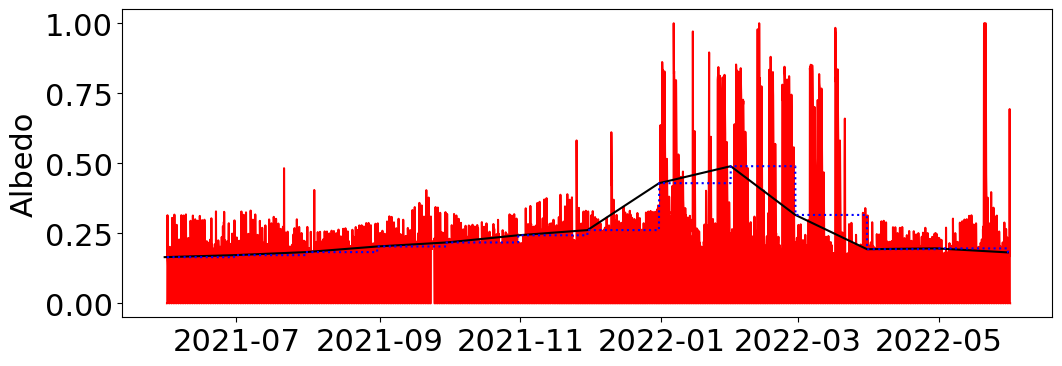

In [32]:
# Monthly SRRL albedo - irradiance weighted
#get_ipython().run_line_magic('matplotlib', 'notebook') #interactive matplotlib
get_ipython().run_line_magic('matplotlib', 'inline') # inline plotting for .py file use

data['SRRL_albedo_weighted'] = (data.SRRL_albedo * data.SRRL_GHI)
data_month = data[['SRRL_albedo_weighted','SRRL_GHI']].resample('M', label='left', closed='left').mean()
data_month['SRRL_albedo_monthly'] = data_month['SRRL_albedo_weighted'] / data_month['SRRL_GHI']
data['SRRL_albedo_monthly'] = data_month['SRRL_albedo_monthly'].reindex(data.index, method='ffill')

plt.figure()
plt.plot(data.SRRL_albedo,'r')
plt.plot(data_month.SRRL_albedo_monthly,'k')
plt.plot(data['SRRL_albedo_monthly'],'b:')
plt.ylabel('Albedo')

In [33]:
data2.keys()

Index(['row2kWh', 'row2dcp', 'row2Gfront', 'Hydra_current_1',
       'Hydra_current_10', 'Hydra_current_11', 'Hydra_current_12',
       'Hydra_current_2', 'Hydra_current_3', 'Hydra_current_4',
       'Hydra_current_5', 'Hydra_current_6', 'Hydra_current_7',
       'Hydra_current_8', 'Hydra_current_9', 'row2temperature_ambient',
       'row2tmod_1', 'row2tmod_2', 'row2wind_direction', 'row2wind_speed',
       'row3Gfront', 'row3Grear_IMT_West', 'row3Grear_IMT_CenterWest',
       'row3Grear_IMT_CenterEast', 'row3Grear_IMT_East', 'row3Grear_CM11',
       'row3Grear_Licor', 'row3Gfront_CM11', 'row3Gfront_Licor', 'row4kWh',
       'row4dcp', 'row4tmod_1', 'row4tmod_2', 'row5Grear', 'row5Gfront',
       'row5temperature_ambient', 'row6tracker_angle', 'row7Grear',
       'row7Gfront', 'row7tracker_angle', 'row7wind_direction',
       'row7wind_speed', 'row7Grear_IMT_CenterEast', 'row7Grear_IMT_East',
       'row7RotatingAlbedometer_CM11_Down', 'row7RotatingAlbedometer_CM11_Up',
       'row8dcp

In [13]:
# save data_das field das data as four .csv files for consumption by pvcaptest
data_das['Hydra_avg'] = data_das[['Hydra_current_1','Hydra_current_2','Hydra_current_3','Hydra_current_4','Hydra_current_5',
                                      'Hydra_current_6','Hydra_current_7','Hydra_current_8','Hydra_current_9','Hydra_current_10',
                                      'Hydra_current_11','Hydra_current_12']].mean(axis=1)
data_das['Hydra_min'] = data_das[['Hydra_current_1','Hydra_current_2','Hydra_current_3','Hydra_current_4','Hydra_current_5',
                                      'Hydra_current_6','Hydra_current_7','Hydra_current_8','Hydra_current_9','Hydra_current_10',
                                      'Hydra_current_11','Hydra_current_12']].min(axis=1)
data_das_out = data_das[['Gfront','Grear', 'row2wind_speed','temp_ambient_FieldAverage',
                        'sunkitty_GRI_CM22', 'SRRL_GHI', 'row7RotatingAlbedometer_CM11_Down',
                        'row7RotatingAlbedometer_CM11_Up','Hydra_avg','Hydra_min',
                        'Yf2','row2tmod_1', 'row2tmod_2', 
                         'Yf4','row4tmod_1', 'row4tmod_2', 
                         'Yf8','row8tmod_1', 'row8tmod_2', 
                         'Yf9', 'row9tmod_1', 'row9tmod_2']]
data_das_out = data_das_out.rename(columns={'Gfront':'Gfront_poa','Yf2':'power_dc_inv2',
                                            'Yf4':'power_dc_inv4','Yf8':'power_dc_inv8','Yf9':'power_dc_inv9', 
                          'sunkitty_GRI_CM22':'albedo_down', 'SRRL_GHI':'albedo_up'})
print(data_das_out.columns)
data_das_out.to_csv(os.path.join('Analysis','data','Rows2-9_2021-2022_15T.csv'))

Index(['Gfront_poa', 'Grear', 'row2wind_speed', 'temp_ambient_FieldAverage',
       'albedo_down', 'albedo_up', 'row7RotatingAlbedometer_CM11_Down',
       'row7RotatingAlbedometer_CM11_Up', 'Hydra_avg', 'Hydra_min',
       'power_dc_inv2', 'row2tmod_1', 'row2tmod_2', 'power_dc_inv4',
       'row4tmod_1', 'row4tmod_2', 'power_dc_inv8', 'row8tmod_1', 'row8tmod_2',
       'power_dc_inv9', 'row9tmod_1', 'row9tmod_2'],
      dtype='object')


In [14]:
# 5-minute data for IEC61724-2 method
data_5min['Hydra_avg'] = data_5min[['Hydra_current_1','Hydra_current_2','Hydra_current_3','Hydra_current_4','Hydra_current_5',
                                      'Hydra_current_6','Hydra_current_7','Hydra_current_8','Hydra_current_9','Hydra_current_10',
                                      'Hydra_current_11','Hydra_current_12']].mean(axis=1)

data_5min_out = data_5min[['Gfront','Grear', 'row2wind_speed','temp_ambient_FieldAverage',
                        'sunkitty_GRI_CM22', 'SRRL_GHI','SRRL_DHI','Hydra_avg',
                        'Yf2','row2tmod_1', 'row2tmod_2', 
                         'Yf4','row4tmod_1', 'row4tmod_2', 
                         'Yf8','row8tmod_1', 'row8tmod_2', 
                         ]]
data_5min_out = data_5min_out.rename(columns={'Gfront':'Gfront_poa','Yf2':'power_dc_inv2',
                                            'Yf4':'power_dc_inv4','Yf8':'power_dc_inv8', 
                          'sunkitty_GRI_CM22':'albedo_down', 'SRRL_GHI':'albedo_up'})

data_5min_out.to_csv(os.path.join('Analysis','data','Rows2-8_2021-2022_5T.csv'))

In [16]:
orga = pd.read_excel('Combinations.xlsx', skiprows = 20)
orga.fillna(method='ffill')

,Method,Sim,WeatherFile_Name,NOTES,DNI,DHI,GHI,POA,BOA,POABOA,...,AmbientTemperature,TrackerAngle,irrad_mod,sky_model,Module,Module Temperature,TestPOA,TestBOA,TestModuleTemp,TestPerformance
0,1,P11,P11,"POA Pyr, monthly albedo",-,-,SRRL_GHI,3,0,1,...,0,0.0,4,2,All tree,NaN,NaN,NaN,NaN,NaN
1,1,00,00,baseline,SRRL_DNI,SRRL_DHI,SRRL_GHI,0,0,0,...,0,0.0,0,2,All tree,NaN,Yes,Yes,Yes,Yes
2,1,A01,A01,Test Albedo,SRRL_DNI,SRRL_DHI,SRRL_GHI,0,0,0,...,0,0.0,0,2,All tree,NaN,Yes,Yes,Yes,Yes
3,1,A02,A02,Test Albedo,SRRL_DNI,SRRL_DHI,SRRL_GHI,0,0,0,...,0,0.0,0,2,All tree,NaN,Yes,Yes,Yes,Yes
4,1,A03,A03,Test Albedo,SRRL_DNI,SRRL_DHI,SRRL_GHI,0,0,0,...,0,0.0,0,2,All tree,NaN,Yes,Yes,Yes,Yes
5,1,A04,A04,Test Albedo,SRRL_DNI,SRRL_DHI,SRRL_GHI,0,0,0,...,0,0.0,0,2,All tree,NaN,Yes,Yes,Yes,Yes
6,1,W01,W01,Test Wind Speed,SRRL_DNI,SRRL_DHI,SRRL_GHI,0,0,0,...,0,0.0,0,2,All tree,NaN,-,-,Yes,Yes
7,1,W02,W02,Test Wind Speed,SRRL_DNI,SRRL_DHI,SRRL_GHI,0,0,0,...,0,0.0,0,2,All tree,NaN,-,-,Yes,Yes
8,1,W03,W03,Test Wind Speed,SRRL_DNI,SRRL_DHI,SRRL_GHI,0,0,0,...,0,0.0,0,2,All tree,NaN,-,-,Yes,Yes
9,1,T01,T01,Test Temperature,SRRL_DNI,SRRL_DHI,SRRL_GHI,0,0,0,...,1,0.0,0,2,All tree,NaN,-,-,Yes,Yes


In [22]:
#for ii in range(0,len(orga)):
ii=14
orga.iloc[ii] 

Method                       1
Sim                        S02
WeatherFile_Name            00
NOTES                      NaN
DNI                   SRRL_DNI
DHI                   SRRL_DHI
GHI                   SRRL_GHI
POA                          0
BOA                          0
POABOA                       0
Albedo                       0
WindSpeed                    0
AmbientTemperature           0
TrackerAngle               0.0
irrad_mod                    2
sky_model                    2
Module                All tree
Module Temperature         NaN
TestPOA                    Yes
TestBOA                    Yes
TestModuleTemp             Yes
TestPerformance            Yes
Name: 14, dtype: object

In [18]:
for ii in range(14, 15): #len(orga)

    savefilevar = os.path.join(InputFilesFolder,'WF_SAM_'+orga.loc[ii]['WeatherFile_Name']+'.csv')
    
    
    POABOA = orga.loc[ii]['POABOA']
    poavar = orga.loc[ii]['POA']
    albvar = orga.loc[ii]['Albedo']
    windvar = orga.loc[ii]['WindSpeed']
    POAvar = orga.loc[ii]['POA']
    BOAvar = orga.loc[ii]['BOA']
    Tvar = orga.loc[ii]['AmbientTemperature']
    
    # poavar
    if poavar == 0:
        poavarname = 'row3Gfront'
    elif poavar == 1:
        poavarname = 'rowGfront_IMT_Average'
    elif poavar == 2:
        poavarname = 'row2Gfront'
    elif poavar == 3:
        poavarname = 'row3Gfront_CM11'
    elif poavar == 4:
        poavarname = 'row3Gfront_Licor'
    elif poavar == 5:
        poavarname = 'row5Gfront'
    elif poavar == 6:
        poavarname = 'row7Gfront'
    elif poavar == 7:
        poavarname = 'row7RotatingAlbedometer_CM11_Up'
    elif poavar == 8:
        poavarname = 'row9Gfront'
    elif poavar == 9:
        poavarname = 'rowGfront_ALL_Averages'
    elif poavar == 10:
        poavarname = 'rowGfront_Broadband_Averages'
    else:
        print("Case Error in poavar.")

              
    # albvar
    if albvar == 0:
        albvarname = 'sunkity_CM11_GRI_over_SRRL_GHI'
    elif albvar == 1:
        albvarname = 'sunkitty_albedo_CM22'
    elif albvar == 2:
        albvarname = 'sunkitty_albedo_IMT'
    elif albvar == 3:
        albvarname = 'sunkitty_albedo_AP'
    elif albvar == 4:
        albvarname = 'SRRL_albedo'
    elif albvar ==5:
        albvarname = 'SRRL_albedo_monthly'
    else:
        print("Case Error in albvar.")
 
    # windvar
    if windvar == 0:
        windvarname = 'row7wind_speed'
    elif windvar == 1:
        windvarname = 'row2wind_speed'
    elif windvar == 2:
        windvarname = 'rowFieldWindSpeedAverage'
    elif windvar == 3:
        windvarname = 'SRRL_windspeed'
    else:
        print("Case Error in windvar.")

    # POAvar
    if POAvar == 0:
        POAvarname = 'row3Gfront'
    elif POAvar == 1:
        POAvarname = 'rowGfront_IMT_Average'
    elif POAvar == 2:
        POAvarname = 'row2Gfront'
    elif POAvar == 3:
        POAvarname = 'row3Gfront_CM11'
    elif POAvar == 4:
        POAvarname = 'row3Gfront_Licor'
    elif POAvar == 5:
        POAvarname = 'row5Gfront'
    elif POAvar == 6:
        POAvarname = 'row7Gfront'
    elif POAvar == 7:
        POAvarname = 'row7RotatingAlbedometer_CM11_Up'
    elif POAvar == 8:
        POAvarname = 'row9Gfront'
    elif POAvar == 9:
        POAvarname = 'rowGfront_ALL_Averages'
    elif POAvar == 10:
        POAvarname = 'rowGfront_Broadband_Averages'
    else:
        print("Case Error in POAvar.")

    # BOAvar
    if BOAvar == 0:
        BOAvarname = 'row3Grear_IMT_Averages'
    elif BOAvar == 1:
        BOAvarname = 'row3Grear_IMT_West'
    elif BOAvar == 2:
        BOAvarname = 'row3Grear_IMT_CenterWest'
    elif BOAvar == 3:
        BOAvarname = 'row3Grear_IMT_CenterEast'
    elif BOAvar == 4:
        BOAvarname = 'row3Grear_IMT_East'
    elif BOAvar == 5:
        BOAvarname = 'row3Grear_CM11'
    elif BOAvar == 6:
        BOAvarname = 'row3Grear_Licor'
    elif BOAvar == 8:
        BOAvarname = 'row5Grear'
    elif BOAvar == 9:
        BOAvarname = 'row7Grear'
    elif BOAvar == 10:
        BOAvarname = 'row7Grear_IMT_CenterEast'
    elif BOAvar == 11:
        BOAvarname = 'row7Grear_IMT_East'
    elif BOAvar == 12:
        BOAvarname = 'row7RotatingAlbedometer_CM11_Down'
    elif BOAvar == 13:
        BOAvarname = 'row9Grear'
    elif BOAvar == 14:
        BOAvarname = 'rowGrear_IMT_Averages'
    elif BOAvar == 15:
        BOAvarname = 'rowGrear_ALL_Averages'
    elif BOAvar == 16:
        BOAvarname = 'rowGrear_Broadband_Averages'
    else:
        print("Case Error in BOAvar.")
        

     # Tvar
    if Tvar == 0:
        Tvarname = 'temp_ambient_FieldAverage'
    elif Tvar == 1:
        Tvarname = 'row2temperature_ambient'
    elif Tvar == 2:
        Tvarname = 'row5temperature_ambient'
    elif Tvar == 3:
        Tvarname = 'SRRL_temperature_ambient'
    else:
        print("Case Error in Tvar.", Tvar)


    if POABOA > 0:
    # Add column of POA instead to Weather File
    
        if POABOA == 1:
        # Column is only front values

            fooPOA = data[POAvarname]

        elif POABOA == 2:
        # Front + Rear IRradiances 
            fooPOA = data[POAvarname] + data[BOAvarname]
        
        saveSAM_WeatherFile(timestamps = data.index, 
                            windspeed = data[windvarname], 
                            temp_amb = data[Tvarname], 
                            Albedo = data[albvarname], 
                            POA = fooPOA,
                            savefile = savefilevar, 
                            includeminute = False)


    else:
        
        saveSAM_WeatherFile(timestamps = data.index, 
                            windspeed = data[windvarname], 
                            temp_amb = data[Tvarname], 
                            Albedo = data[albvarname], 
                            DHI = data.SRRL_DHI, DNI = data.SRRL_DNI, GHI = data.SRRL_GHI,
                            savefile = savefilevar, 
                            includeminute = False)



In [15]:
data_5min_out.columns

Index(['Gfront_poa', 'Grear', 'row2wind_speed', 'temp_ambient_FieldAverage',
       'albedo_down', 'albedo_up', 'SRRL_DHI', 'Hydra_avg', 'power_dc_inv2',
       'row2tmod_1', 'row2tmod_2', 'power_dc_inv4', 'row4tmod_1', 'row4tmod_2',
       'power_dc_inv8', 'row8tmod_1', 'row8tmod_2'],
      dtype='object')

In [60]:
# save 5-minute IEC files - Option1B (GHI,DHI,Albedo), Option2A (POA+BOA), Option2B (RefMod POA)
saveSAM_WeatherFile(timestamps = data_5min_out.index, 
                    windspeed = data_5min_out['row2wind_speed'], 
                    temp_amb = data_5min_out['temp_ambient_FieldAverage'], 
                    Albedo = data_5min_out['albedo_down'] / data_5min_out['albedo_up'] , 
                    DHI = data_5min_out.SRRL_DHI,  GHI = data_5min_out.albedo_up,
                    savefile = os.path.join(InputFilesFolder,'WF_SAM_IEC1B.csv'), 
                    includeminute = True)

In [61]:
# save 5-minute IEC files - Option2 (Gpoa for Row8)
saveSAM_WeatherFile(timestamps = data_5min_out.index, 
                    windspeed = data_5min_out['row2wind_speed'], 
                    temp_amb = data_5min_out['temp_ambient_FieldAverage'], 
                    Albedo = data_5min_out['albedo_down'] / data_5min_out['albedo_up'] , 
                    POA = data_5min_out.Gfront_poa,
                    savefile = os.path.join(InputFilesFolder,'WF_SAM_IEC2Mono.csv'), 
                    includeminute = True)

In [62]:
# save 5-minute IEC files - Option2A (Gpoa+Bifi*Gboa POA)
saveSAM_WeatherFile(timestamps = data_5min_out.index, 
                    windspeed = data_5min_out['row2wind_speed'], 
                    temp_amb = data_5min_out['temp_ambient_FieldAverage'], 
                    Albedo = data_5min_out['albedo_down'] / data_5min_out['albedo_up'] , 
                    POA = data_5min_out.Gfront_poa + 0.72*data_5min_out.Grear,
                    savefile = os.path.join(InputFilesFolder,'WF_SAM_IEC2A.csv'), 
                    includeminute = True)

In [16]:
# save 5-minute IEC files - Option2B (RefMod POA) TEMPERATURE CORRECT FIRST!!
saveSAM_WeatherFile(timestamps = data_5min_out.index, 
                    windspeed = data_5min_out['row2wind_speed'], 
                    temp_amb = data_5min_out['temp_ambient_FieldAverage'], 
                    Albedo = data_5min_out['albedo_down'] / data_5min_out['albedo_up'] , 
                    POA = data_5min_out['Hydra_avg']*1000 / 9.54 * (1-.00054 *(data_5min_out.row2tmod_2-25)),
                    savefile = os.path.join(InputFilesFolder,'WF_SAM_IEC2B_tcorr.csv'), 
                    includeminute = True)